In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import nussl
from utils import viz, data
import yaml

In [2]:
checkpoint_path = 'models/test_stft_mask/checkpoints/best.model.pth'
config_path = 'config/stft_mask.yml'

In [3]:
from models.MaskInference import MaskInference
nussl.ml.register_module(MaskInference)

In [4]:
model_checkpoint = torch.load(checkpoint_path,map_location=torch.device('cpu'))

In [5]:
model_checkpoint['metadata'].keys()

dict_keys(['config', 'nussl_version', 'stft_params', 'sample_rate', 'num_channels', 'train_dataset', 'trainer.state_dict', 'trainer.state.epoch_history'])

In [6]:
model_checkpoint['metadata']['trainer.state_dict']

{'epoch': 10,
 'epoch_length': 10,
 'max_epochs': 10,
 'output': {'loss_L1': 0.00045414676424115896, 'loss': 0.00045414676424115896},
 'metrics': {'avg_loss': 0.0003443538566495934},
 'seed': None}

In [7]:
val_loss = model_checkpoint['metadata']['trainer.state.epoch_history']['validation/loss']
train_loss = model_checkpoint['metadata']['trainer.state.epoch_history']['train/loss']
n_epochs = model_checkpoint['metadata']['trainer.state_dict']['epoch']

Text(0.5, 0, 'Epoch')

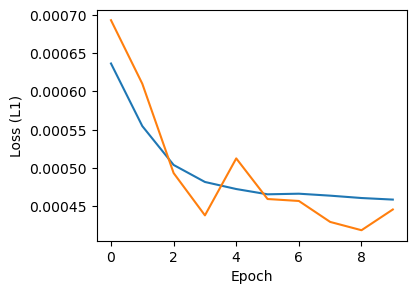

In [8]:
x = np.arange(n_epochs)
plt.figure(figsize=(4,3))
plt.plot(x,val_loss)
plt.plot(x,train_loss)
plt.ylabel('Loss (L1)')
plt.xlabel('Epoch')

In [9]:
separator = nussl.separation.deep.DeepMaskEstimation(
    nussl.AudioSignal(), model_path=checkpoint_path,
    device='cpu',
)

/SFS/user/ry/stonekev/miniconda3/envs/audio/lib/python3.10/site-packages/nussl/separation/base/separation_base.py:73: UserWarning: input_audio_signal has no data!
  warnings.warn('input_audio_signal has no data!')
/SFS/user/ry/stonekev/miniconda3/envs/audio/lib/python3.10/site-packages/nussl/core/audio_signal.py:455: UserWarning: Initializing STFT with data that is non-complex. This might lead to weird results!
  warnings.warn('Initializing STFT with data that is non-complex. '
/SFS/user/ry/stonekev/miniconda3/envs/audio/lib/python3.10/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [12]:
#Load yaml configs into configs dictionary
with open(config_path,'r') as f:
    configs = yaml.safe_load(f)
    f.close()
stft_params = nussl.STFTParams(**configs['stft_params'])

test_folder = configs['test_folder']
test_data = data.mixer(stft_params, transform=None, fg_path=configs['valid_folder'], num_mixtures=999999, coherent_prob=1.0)
item = test_data[0]
separator.audio_signal = item['mix']

In [13]:
estimates = separator()
estimates.append(item['mix'] - estimates[0])

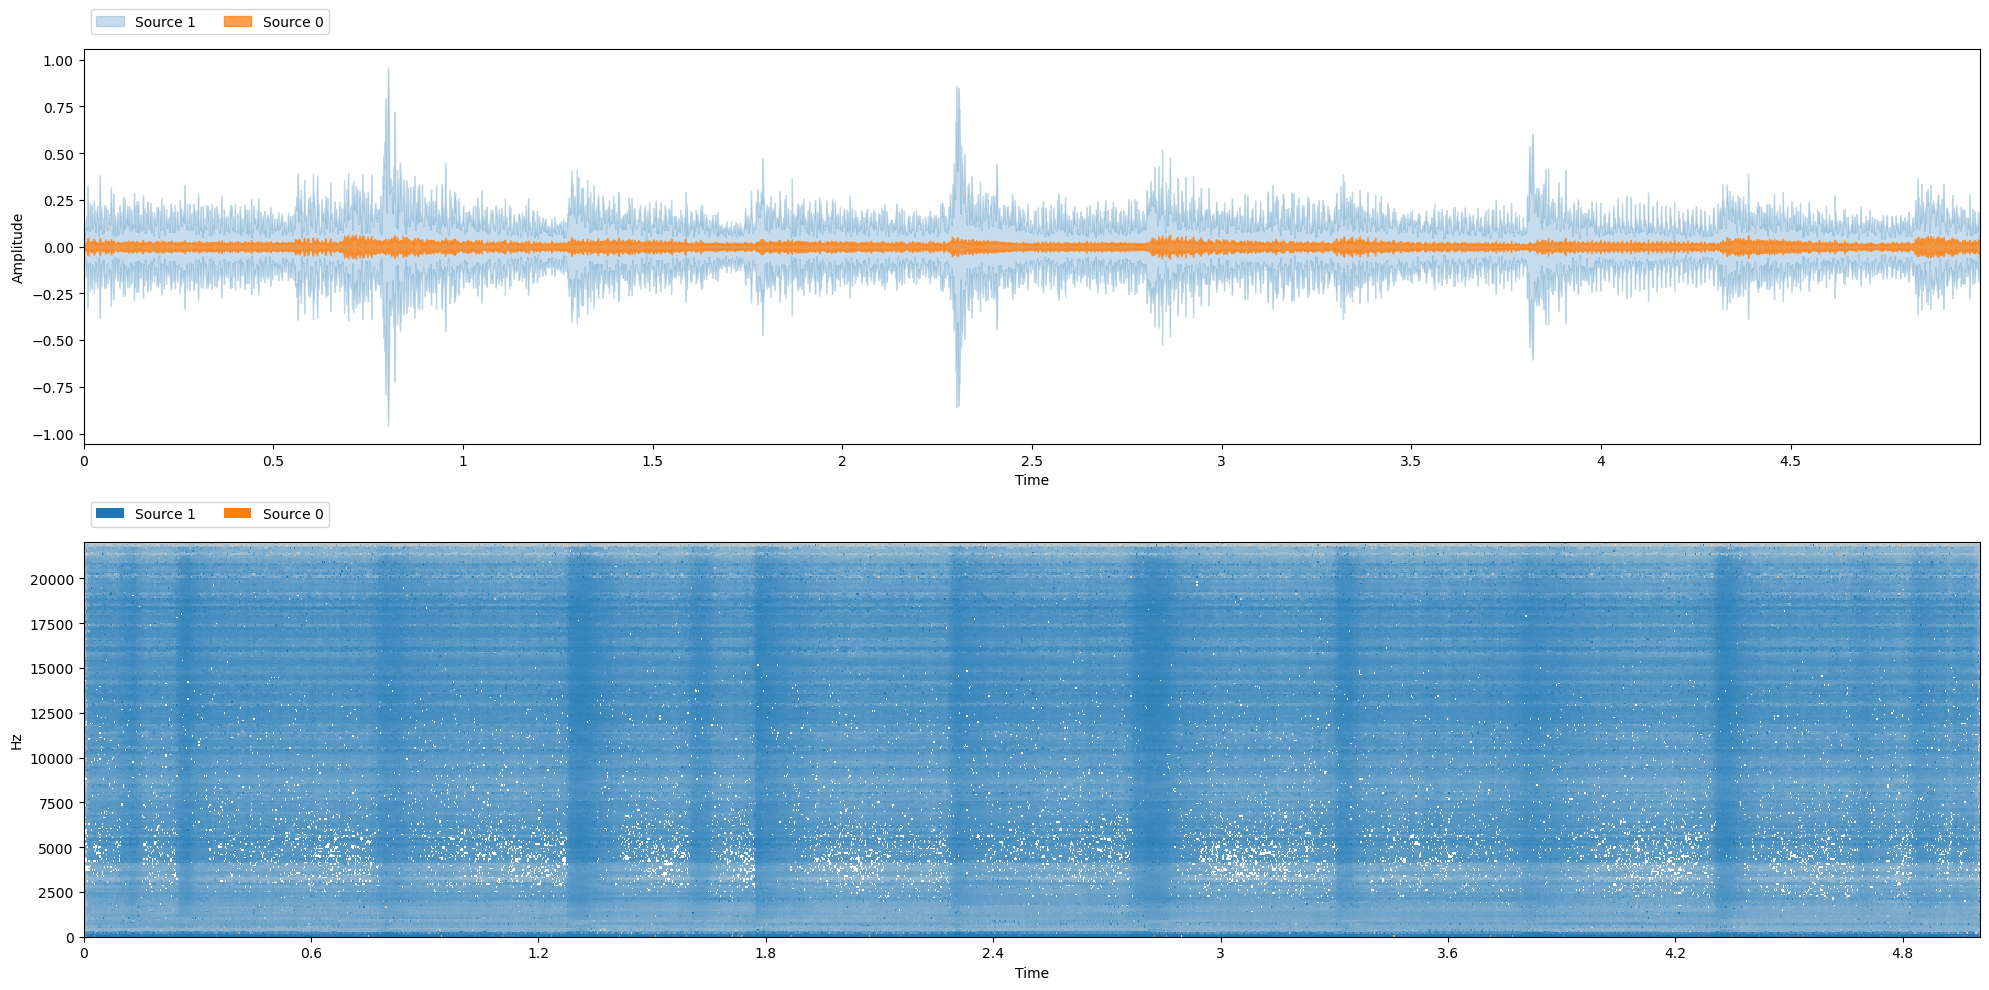


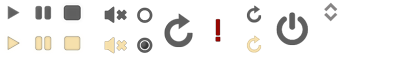
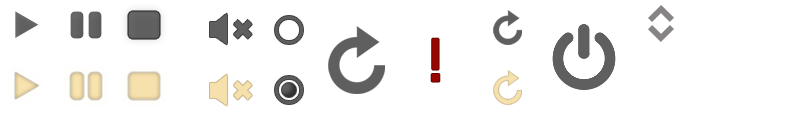
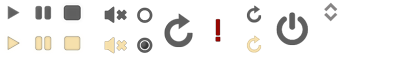

In [14]:
viz.show_sources(estimates)